# 1. GAN
- ## CNN 구조와 GAN을 결합한 DCGAN을 이용하여 꽃 이미지를 생성하기
- ## Kaggle의 Flowers imitation Dataset을 사용

### 참고링크
- https://goldenrabbit.co.kr/2023/07/31/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EB%94%A5%EB%9F%AC%EB%8B%9D-gan%EC%9C%BC%EB%A1%9C-%EC%82%AC%EB%9E%8C-%EC%96%BC%EA%B5%B4-%EB%A7%8C%EB%93%A4%EA%B8%B0/
- https://honeycomb-makers.tistory.com/18
- https://ws-choi.github.io/blog-kor/seminar/tutorial/mnist/pytorch/gan/GAN-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/
- https://kangbk0120.github.io/articles/2017-08/dcgan-pytorch
- https://whereisend.tistory.com/263

### 1. 데이터 불러오기 및 시각화

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터셋 불러오기
!cp "/content/drive/MyDrive/flower.zip" "."
!unzip "./flower.zip" -d "./GAN/"

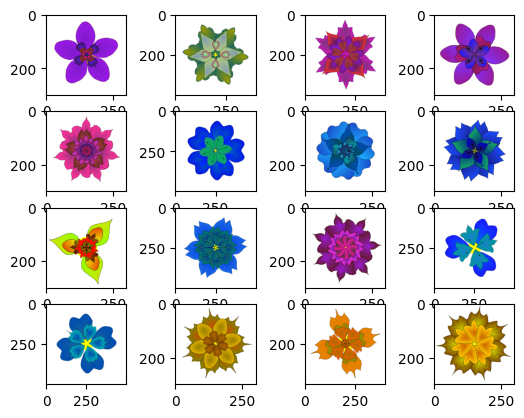

In [ ]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

path = "/content/GAN/flowers_imitation"
imgs = glob.glob(os.path.join(path, "*"))

# 이미지 16개 시각화
for i in range(16):
  plt.subplot(4, 4, i + 1)
  img = Image.open(imgs[i])
  plt.imshow(img)
plt.show()

### 2. Parser 정의


In [ ]:
import argparse
import easydict

# parser 생성
parser = argparse.ArgumentParser(description = 'Flower Generator by DCGAN')

# 하이퍼파라미터 추가
args = easydict.EasyDict({
    "batch_size" : 128,
    "epoch" : 50,
    "lr" : 0.0001,
    "channels" : 3,
    "noise" : 100,
    "feature_g" : 64,
    "feature_d" : 64,
})

ngpu = 1

### 3. 이미지 데이터 전처리

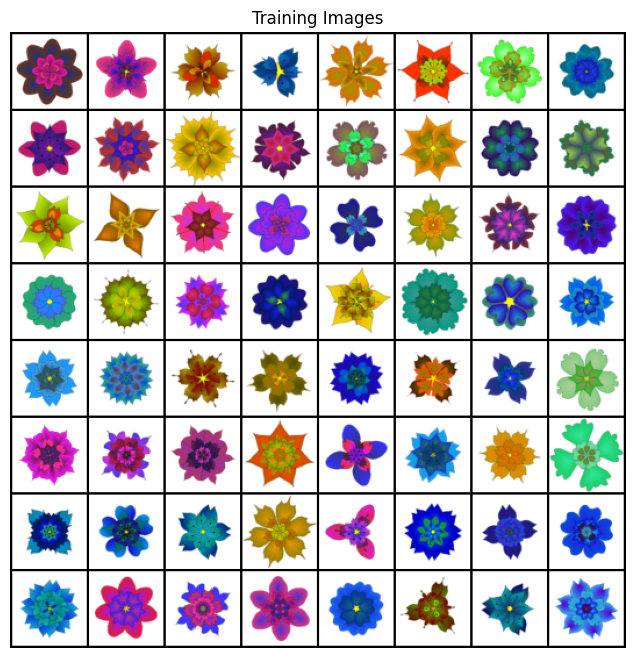

In [ ]:
import numpy as np
import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

# 이미지 전처리
tf = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root = "/content/GAN",
    transform = tf
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size,
                                         shuffle = True, num_workers = 2)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(), (1, 2, 0)))

In [ ]:
print(len(dataloader))

39


### 4. 가중치 초기화

In [ ]:
def weights_init(m):
  # 층의 종류
  classname = m.__class__.__name__

  # 합성곱층
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)

  # 배치 정규화
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

### 5. GAN Generator


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu

    # 생성자 구성 층 정의
    self.gen = nn.Sequential(
        # convolution. 100 * 4 * 4
        nn.ConvTranspose2d(args.noise, args.feature_g * 8,
                           kernel_size = 4, bias = False),
        nn.BatchNorm2d(args.feature_g * 8),
        nn.ReLU(True),

        # (64 * 8) * 4 * 4
        nn.ConvTranspose2d(args.feature_g * 8, args.feature_g * 4,
                           kernel_size = 4, stride = 2,
                           padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_g * 4),
        nn.ReLU(True),

        # (64 * 4) * 8 * 8
        nn.ConvTranspose2d(args.feature_g * 4, args.feature_g * 2,
                           kernel_size = 4, stride = 2,
                           padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_g * 2),
        nn.ReLU(True),

        # (64 * 2) * 16 * 16
        nn.ConvTranspose2d(args.feature_g * 2, args.feature_g,
                           kernel_size = 4, stride = 2,
                           padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_g),
        nn.ReLU(True),

        # 64 * 32 * 32
        nn.ConvTranspose2d(args.feature_g, args.channels,
                           kernel_size = 4, stride = 2,
                           padding = 1, bias = False),
        nn.Tanh()

        # 최종 : 3 * 64 * 64
    )

  def forward(self, input):
    return self.gen(input)

In [ ]:
netG = Generator(ngpu).to(device)
# multi-gpu
if(device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 6. GAN Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu

    # 감별자 구성 층 정의
    self.disc = nn.Sequential(
        nn.Conv2d(args.channels, args.feature_d,
                  kernel_size = 4, stride = 2,
                  padding = 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        # 64 * 32 * 32
        nn.Conv2d(args.feature_d, args.feature_d * 2,
                  kernel_size = 4, stride = 2,
                  padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_d * 2),
        nn.LeakyReLU(0.2, inplace = True),

        # (64 * 2) * 16 * 16
        nn.Conv2d(args.feature_d * 2, args.feature_d * 4,
                  kernel_size = 4, stride = 2,
                  padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_d * 4),
        nn.LeakyReLU(0.2, inplace = True),

        # (64 * 4) * 8 * 8
        nn.Conv2d(args.feature_d * 4, args.feature_d * 8,
                  kernel_size = 4, stride = 2,
                  padding = 1, bias = False),
        nn.BatchNorm2d(args.feature_d * 8),
        nn.LeakyReLU(0.2, inplace = True),

        # (64 * 8) * 4 * 4
        nn.Conv2d(args.feature_d * 8, 1, kernel_size = 4,
                  stride = 1, padding = 0, bias = False),
        nn.Sigmoid()

        # 최종 : 1 * 1 * 1
    )

  def forward(self, input):
    return self.disc(input)

In [ ]:
netD = Discriminator(ngpu).to(device)
# multi-gpu
if(device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### 7. 모델 학습


7 - 1. Generator와 Discriminator 생성 및 가중치 초기화

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()

# Latent Vector의 배치 생성
fixed_noise = torch.randn(64, 100, 1, 1, device = device)

realLabel = 1
fakeLabel = 0

Doptim = optim.Adam(netD.parameters(), lr = args.lr, betas = (0.5, 0.999))
Goptim = optim.Adam(netG.parameters(), lr = args.lr, betas = (0.5, 0.999))

7 - 2. Discriminator 및 Generator 학습

In [ ]:
img_list = []
GLosses = []
DLosses = []
iters = 0
epo = 200

print("start training")

for epochs in range(epo):
  for i, data in enumerate(dataloader, 0):

    """Discriptor"""
    netD.zero_grad()

    # descriptor에 실제 이미지 입력
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), realLabel,
                       dtype = torch.float, device = device)

    # 실제 이미지에 대한 오차 계산
    output = netD(real_cpu).view(-1)
    DiscLossReal = criterion(output, label)
    DiscLossReal.backward()
    Dx = output.mean().item()

    # 가짜 이미지 생성
    noise = torch.randn(b_size, 100, 1, 1, device = device)
    fake = netG(noise)
    label.fill_(fakeLabel)

    # descriptor에 가짜 이미지 입력
    output = netD(fake.detach()).view(-1)

    # 가짜 이미지에 대한 오차 계산
    DiscLossFake = criterion(output, label)
    DiscLossFake.backward()
    DGz1 = output.mean().item()

    # Descriptor의 전체 오차 학습
    DiscLoss = DiscLossReal + DiscLossFake
    Doptim.step()

    """Generator"""
    netG.zero_grad()
    label.fill_(realLabel)
    output = netD(fake).view(-1)
    GenLoss = criterion(output, label)
    GenLoss.backward()
    DGz2 = output.mean().item()
    Goptim.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %f\tLoss_g: %f\tD(x): %f\tD(G(z)): %f / %f'
            % (epochs, epo, i, len(dataloader), DiscLoss.item(), GenLoss.item(),
            Dx, DGz1, DGz2))
    DLosses.append(DiscLoss.item())
    GLosses.append(GenLoss.item())

    if (iters %  13 == 0) or ((epochs == epo - 1) and (i == len(dataloader) - 1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))

    iters += 1

print("training finish")

start training
[0/200][0/39]	Loss_D: 1.661532	Loss_g: 1.798116	D(x): 0.359500	D(G(z)): 0.347579 / 0.211675
[1/200][0/39]	Loss_D: 0.078839	Loss_g: 6.700979	D(x): 0.972059	D(G(z)): 0.046603 / 0.001678
[2/200][0/39]	Loss_D: 0.676310	Loss_g: 14.802483	D(x): 0.993746	D(G(z)): 0.434488 / 0.000001
[3/200][0/39]	Loss_D: 0.048790	Loss_g: 7.298050	D(x): 0.990164	D(G(z)): 0.037274 / 0.000953
[4/200][0/39]	Loss_D: 0.028454	Loss_g: 7.396903	D(x): 0.995221	D(G(z)): 0.023197 / 0.000812
[5/200][0/39]	Loss_D: 0.017070	Loss_g: 6.983324	D(x): 0.997104	D(G(z)): 0.013968 / 0.001235
[6/200][0/39]	Loss_D: 0.034039	Loss_g: 6.599022	D(x): 0.987605	D(G(z)): 0.009584 / 0.001689
[7/200][0/39]	Loss_D: 0.017285	Loss_g: 6.754908	D(x): 0.995810	D(G(z)): 0.012883 / 0.001371
[8/200][0/39]	Loss_D: 0.017584	Loss_g: 6.765340	D(x): 0.991952	D(G(z)): 0.008439 / 0.001313
[9/200][0/39]	Loss_D: 0.245577	Loss_g: 31.690893	D(x): 0.997393	D(G(z)): 0.212166 / 0.000000
[10/200][0/39]	Loss_D: 0.006674	Loss_g: 6.517951	D(x): 0.995434

### 8. 모델 성능 평가 및 시각화

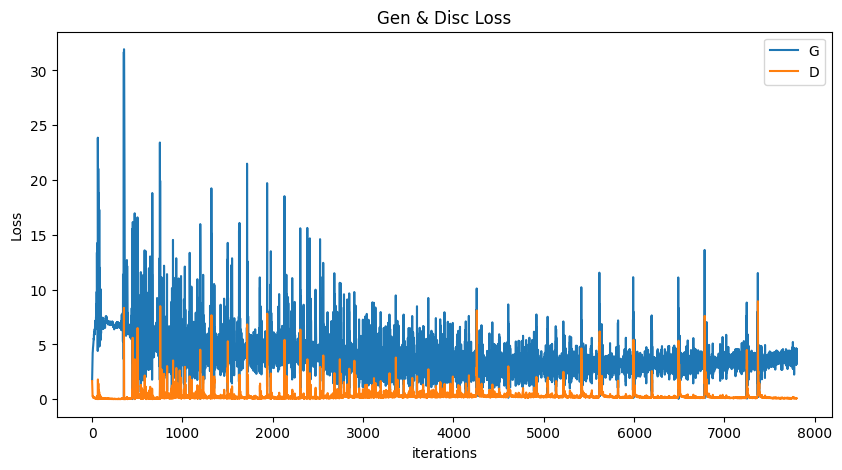

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Gen & Disc Loss")
plt.plot(GLosses, label = "G")
plt.plot(DLosses, label = "D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay = 1000, blit = True)

HTML(ani.to_jshtml())